# Check updated initial MOM5 condition
see https://github.com/COSIMA/access-om2/issues/206

In [1]:
# import cosima_cookbook as cc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib import cm
# from mpl_toolkits.basemap import Basemap # plot on map projections
# import netCDF4 as nc
# import IPython.display
# import cmocean
from glob import glob
import os
# import sys
# import yaml
# import math
import xarray as xr
import copy
from collections import OrderedDict

In [15]:
files = {
    '1 deg': {
        'old': '/g/data/ik11/inputs/access-om2/input_20200530/mom_1deg/ocean_temp_salt.res.nc',
        'new': '/g/data/ik11/inputs/access-om2/woa13/10/woa13_ts_01_mom10.nc'
    },
    '0.25 deg': {
        'old': '/g/data/ik11/inputs/access-om2/input_20200530/mom_025deg/ocean_temp_salt.res.nc',
        'new': '/g/data/ik11/inputs/access-om2/woa13/025/woa13_ts_01_mom025.nc'
    },
    '0.1 deg': {
        'old': '/g/data/ik11/inputs/access-om2/input_20200530/mom_01deg/ocean_temp_salt.res.nc',
        'new': '/g/data/ik11/inputs/access-om2/woa13/01/woa13_ts_01_mom01.nc'
    }
}

## Histograms of changes

1 deg temp
mean (red) = -0.00006

percentiles (green):
1% = -0.08993
5% = -0.03113
25% = -0.00182
50% = 0.00077
75% = 0.00403
95% = 0.01744
99% = 0.09006
0.25 deg temp
mean (red) = 0.00085

percentiles (green):
1% = -0.09118
5% = -0.02705
25% = -0.00033
50% = 0.00171
75% = 0.00453
95% = 0.01493
99% = 0.09195
0.1 deg temp
mean (red) = 0.00096

percentiles (green):
1% = -0.09118
5% = -0.02924
25% = -0.00037
50% = 0.00189
75% = 0.00480
95% = 0.01637
99% = 0.09491
1 deg salt
mean (red) = 0.00000

percentiles (green):
1% = -0.00000
5% = -0.00000
25% = -0.00000
50% = 0.00000
75% = 0.00000
95% = 0.00000
99% = 0.00000
0.25 deg salt
mean (red) = 0.00000

percentiles (green):
1% = -0.00000
5% = -0.00000
25% = -0.00000
50% = 0.00000
75% = 0.00000
95% = 0.00000
99% = 0.00000
0.1 deg salt
mean (red) = 0.00000

percentiles (green):
1% = -0.00000
5% = -0.00000
25% = 0.00000
50% = 0.00000
75% = 0.00000
95% = 0.00000
99% = 0.00000


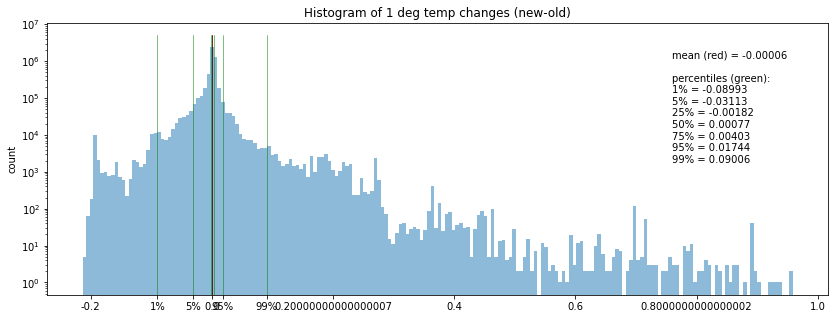

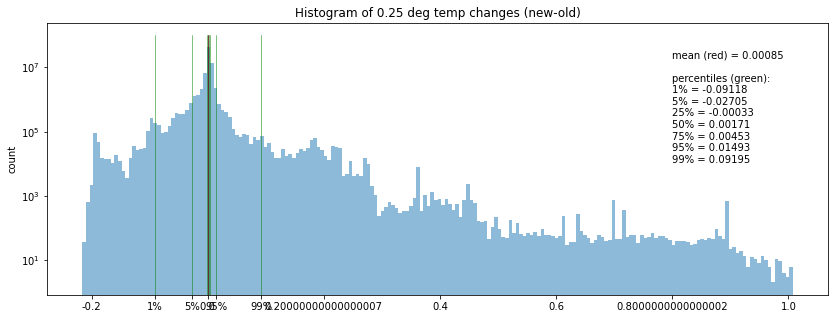

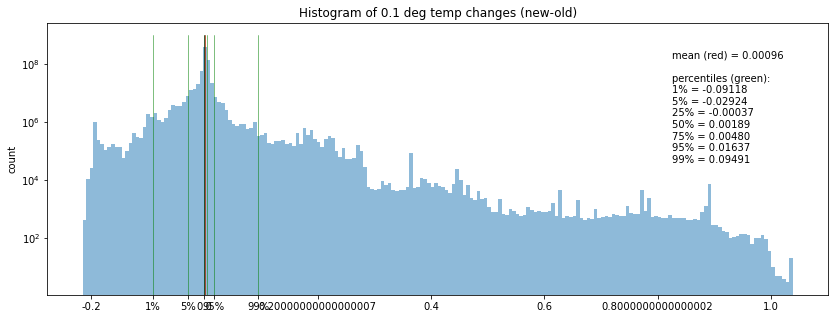

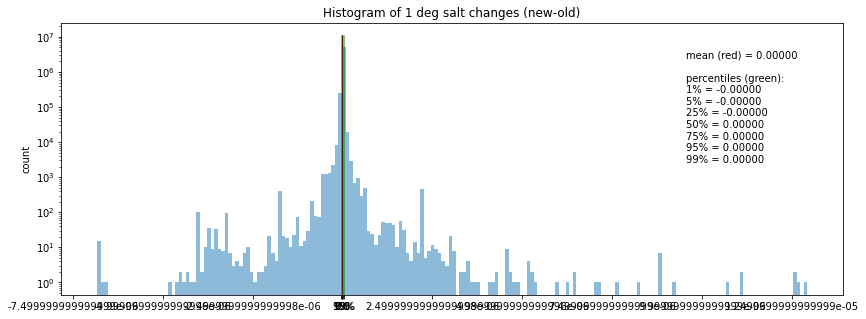

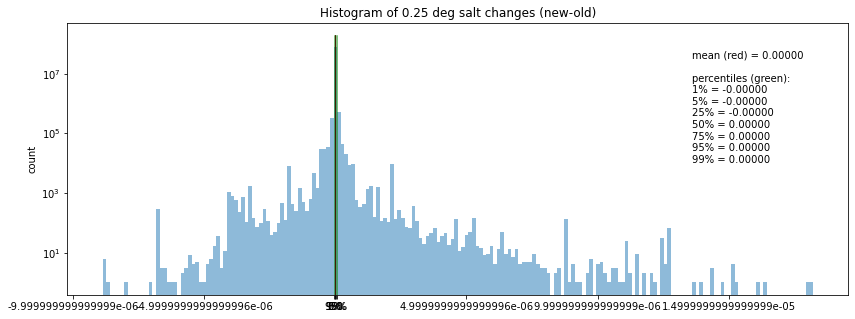

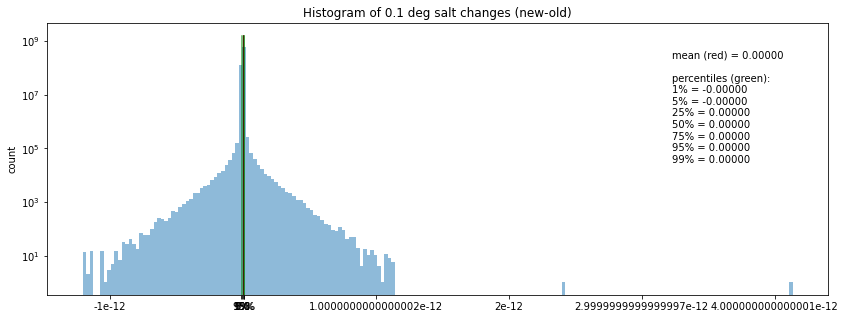

In [16]:
variables = ['temp', 'salt']
for v in variables:
    for res, f in files.items():
        fig, ax1  = plt.subplots(1,1,figsize=(14,5))
        plt.subplot(1,1,1)
        old = xr.open_dataset(f['old'])[v].isel(time=0).load().data
        new = xr.open_dataset(f['new'])[v].isel(time=0).load().data
        difference = np.ma.ravel(new - old).data
        difference = difference[np.logical_not(np.isnan(difference))]
        difference = difference[np.isfinite(difference)]

        percentiles = [1, 5, 95, 99]
        percentile_vals = np.percentile(difference, percentiles)
        plt.hist(difference, bins=200, alpha=0.5)
        plt.ylabel('count')
        plt.title('Histogram of '+res+' '+v+' changes (new-old)');
        plt.yscale('log', nonpositive='clip')
        locs, _ = plt.xticks()
        labels = [str(x) for x in locs]
        locs = np.concatenate((locs, percentile_vals))
        labels += [str(p)+'%' for p in percentiles]
        plt.xticks(locs, labels)
        m = np.mean(difference)
        stats = 'mean (red) = {:.5f}'.format(m)
        stats += '\n\npercentiles (green):'
        percentiles = [1, 5, 25, 50, 75, 95, 99]
        percentile_vals = np.percentile(difference, percentiles)
        for (p, pv) in zip(percentiles, percentile_vals):
            stats += '\n{}% = {:.5f}'.format(p, pv)
        plt.text(.8, .9, stats, transform = ax1.transAxes, verticalalignment='top')
        _, ymax = plt.ylim()
        print(res, v)
        print(stats)
        for p in percentile_vals:
            plt.plot([p, p],[0, ymax],'g',linewidth=0.5)      
        plt.plot([m, m],[0, ymax],'r',linewidth=0.5)      
        plt.plot([0, 0],[0, ymax],'k',linewidth=0.5)

In [ ]:
del old, new

## Bivariate histograms of changes

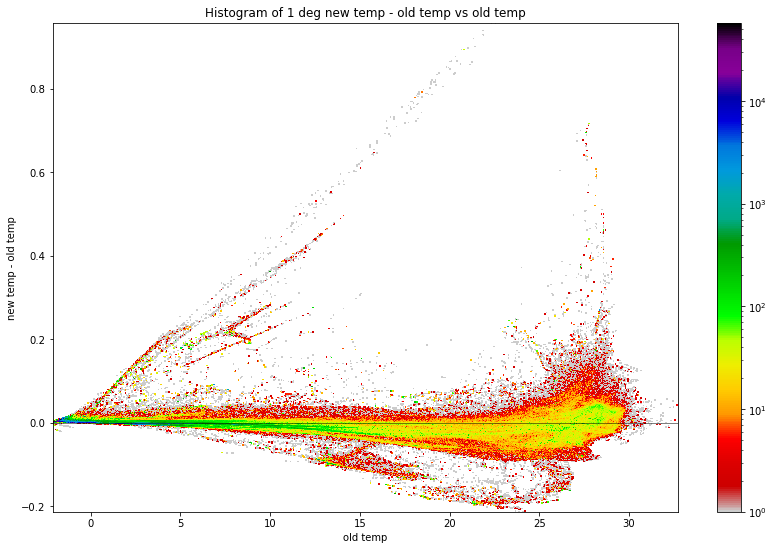

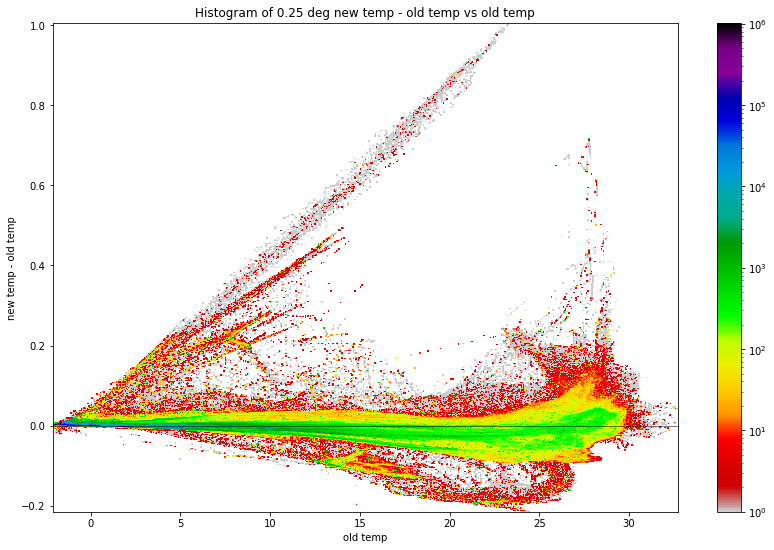

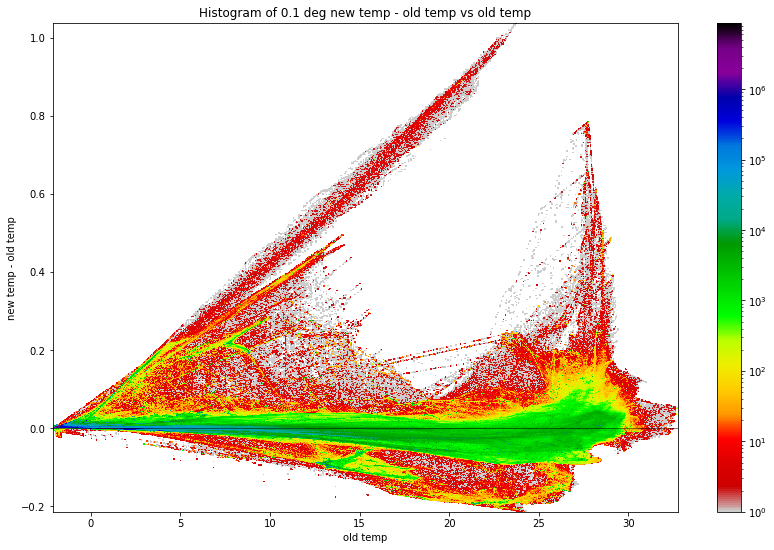

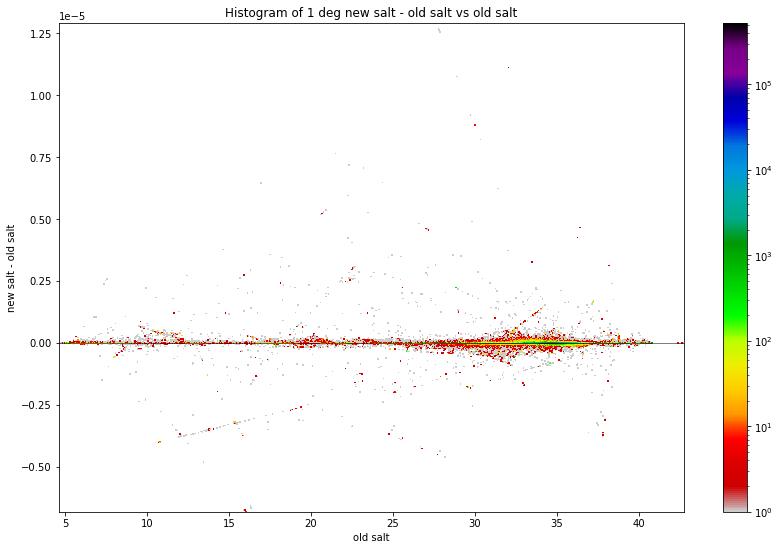

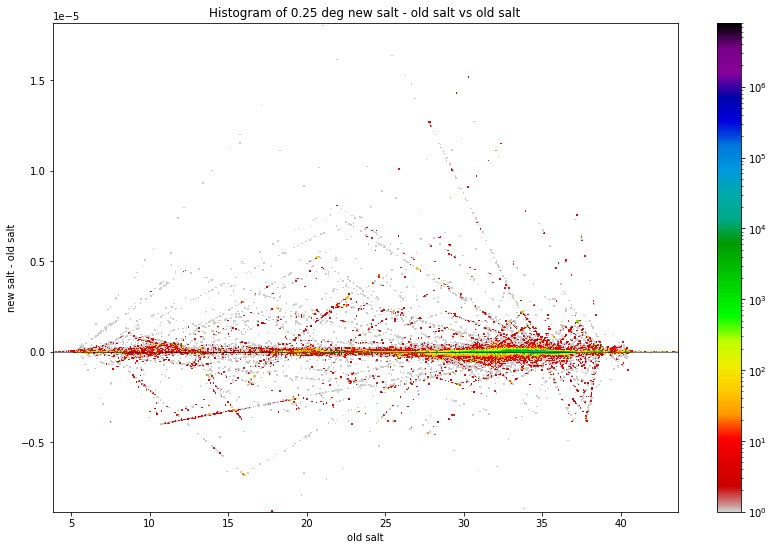

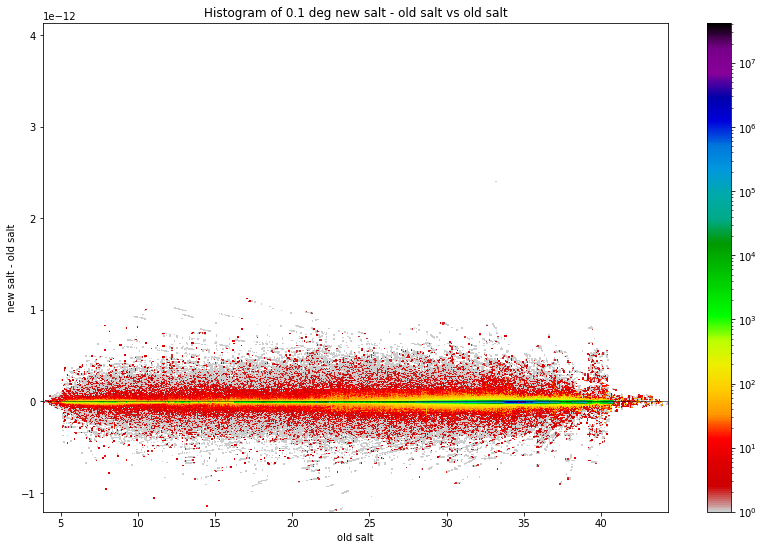

In [19]:
variables = ['temp', 'salt']
bins = 1000
for v in variables:
    for res, f in files.items():
        fig, ax1  = plt.subplots(1,1,figsize=(14,9))
        plt.subplot(1,1,1)
        x = xr.open_dataset(f['old'])[v].isel(time=0).data #.load()
        y = xr.open_dataset(f['new'])[v].isel(time=0).data #.load()
        bad = np.logical_or(np.isnan(x), np.isnan(y))
        x = x[np.logical_not(bad)]
        y = y[np.logical_not(bad)]
        y = y-x
        plt.hist2d(x,y, bins=bins, cmap=plt.cm.get_cmap('nipy_spectral_r'), norm=mpl.colors.LogNorm(), density=False)
        plt.colorbar()
        plt.plot([x.min(), x.max()],[0,0],'k',linewidth=0.5)
        plt.xlabel('old '+v)
        plt.ylabel('new '+v+' - old '+v)
        plt.title('Histogram of '+res+' new '+v+' - old '+v+' vs old '+v)
        plt.xlim([x.min(), x.max()])

In [42]:
del x,y

## Maps of differences

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.07/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


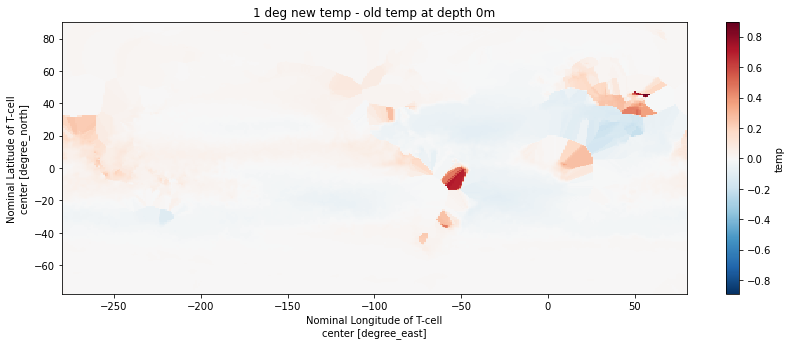

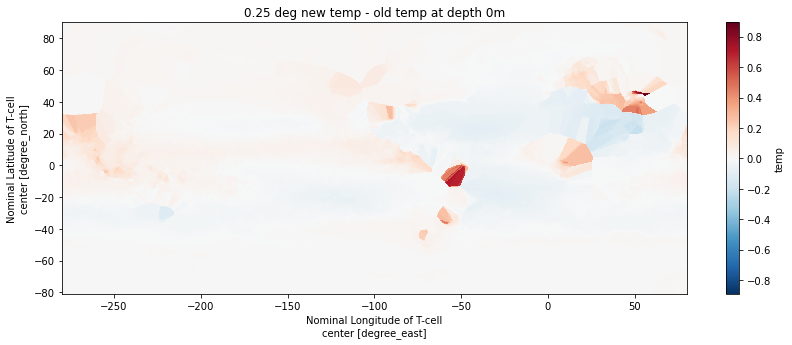

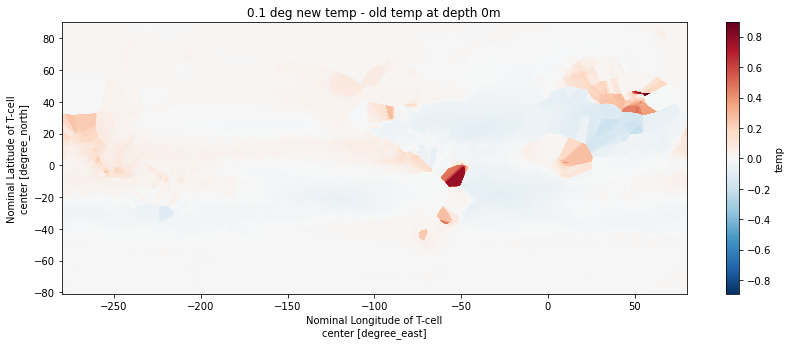

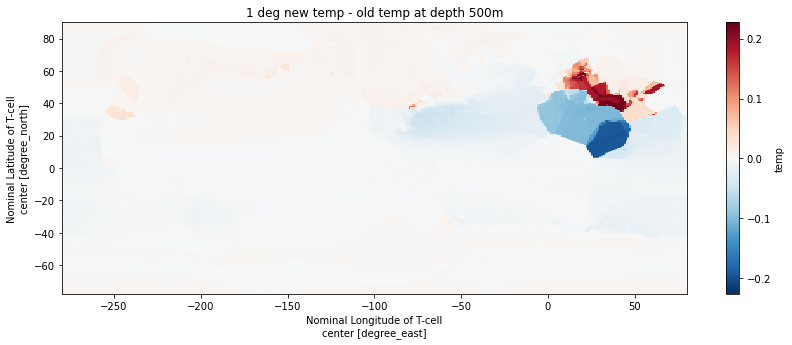

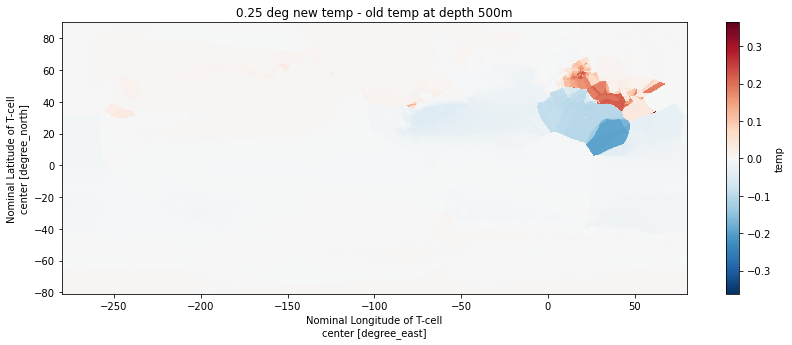

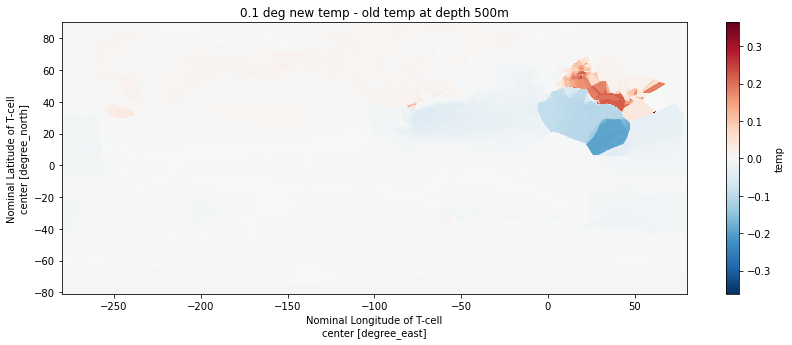

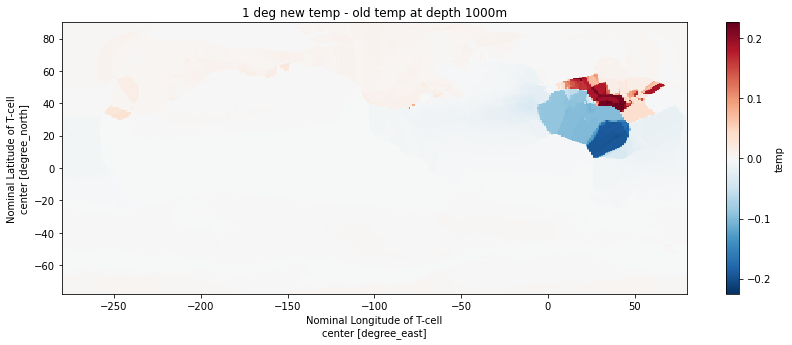

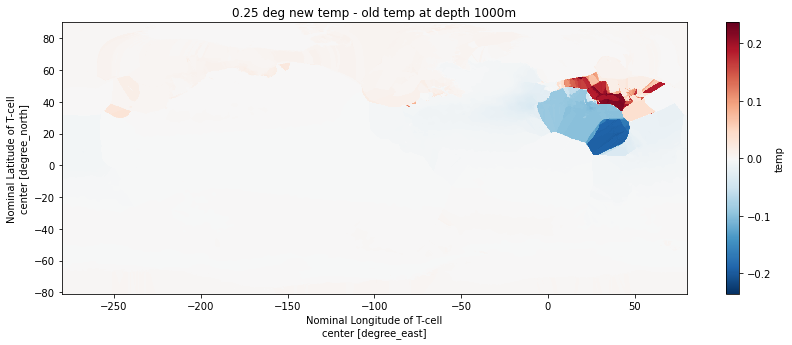

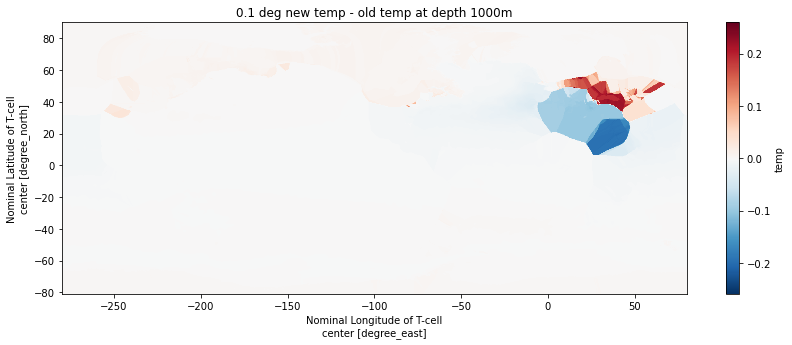

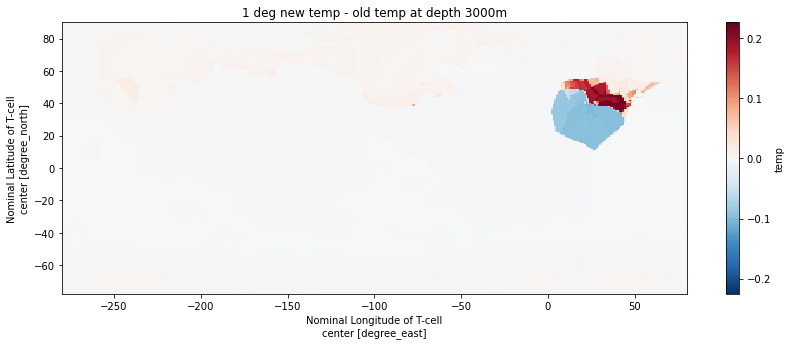

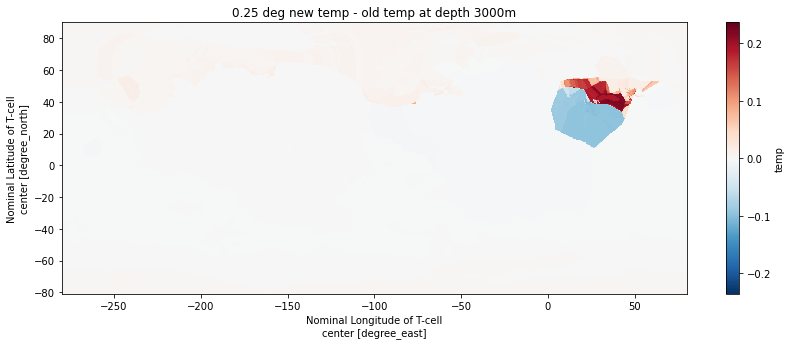

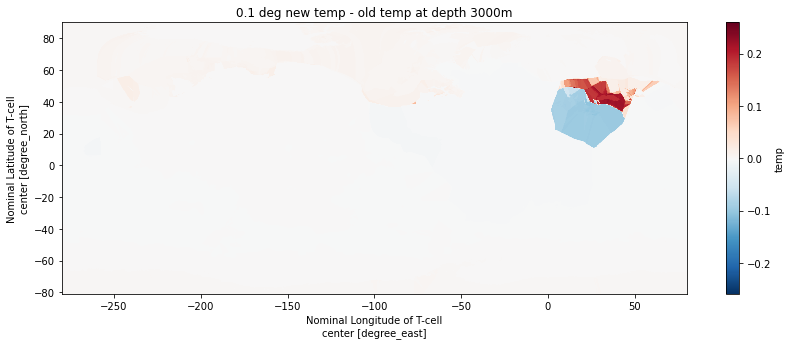

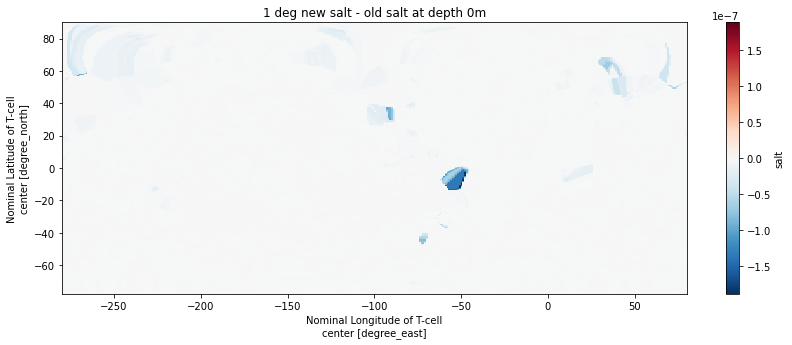

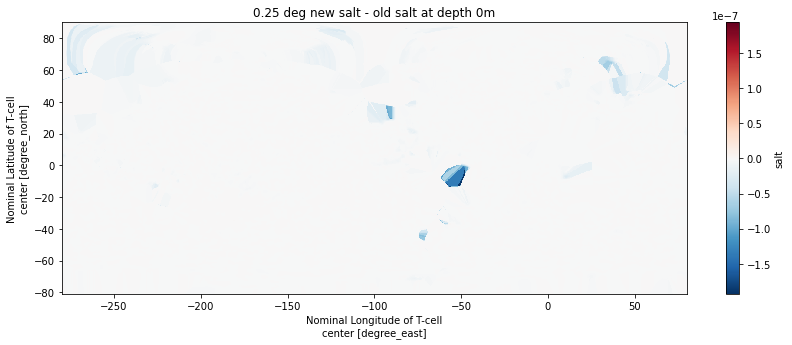

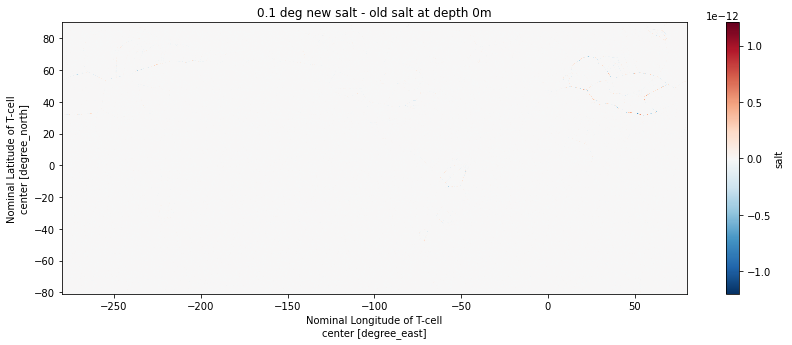

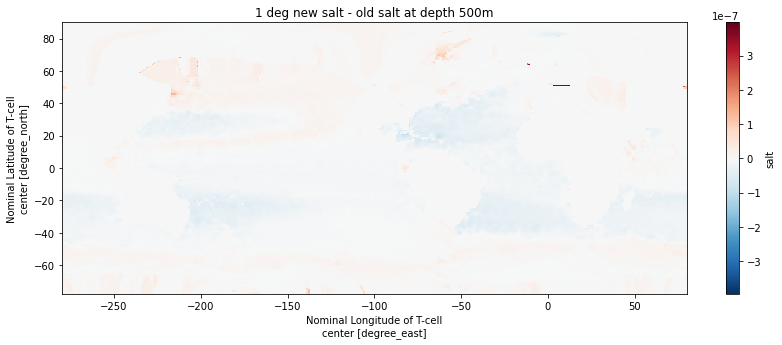

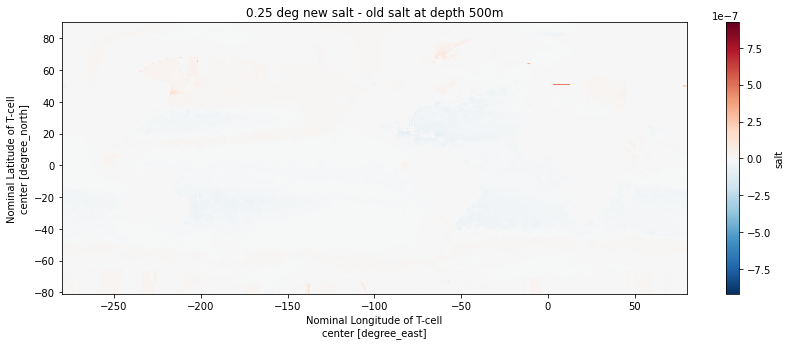

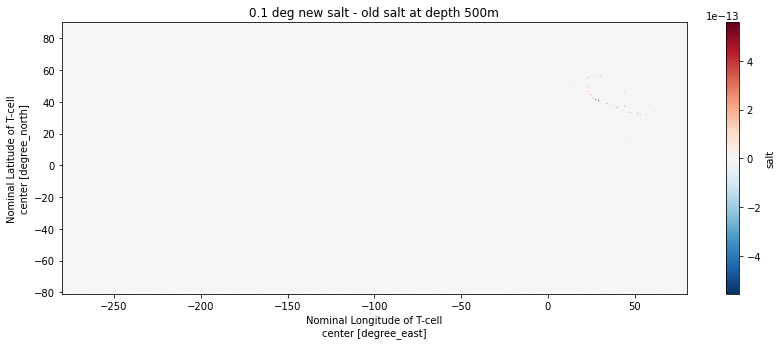

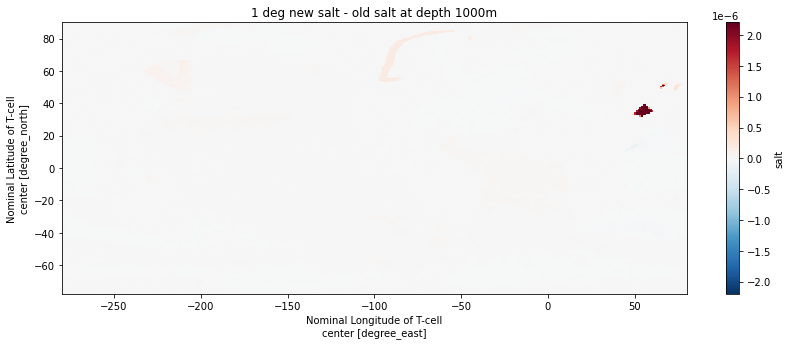

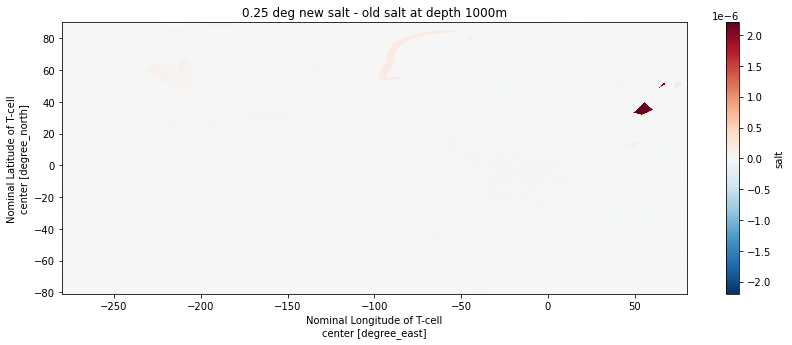

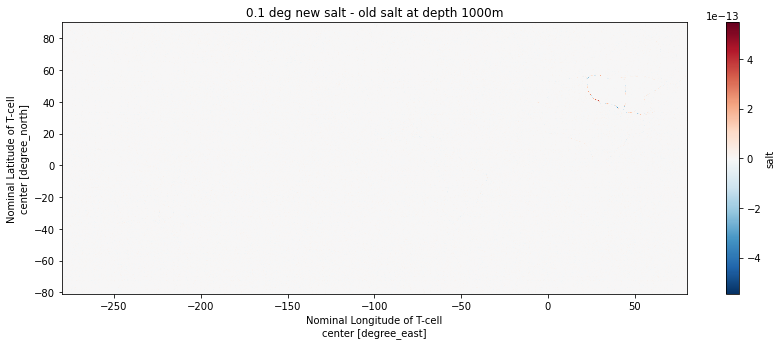

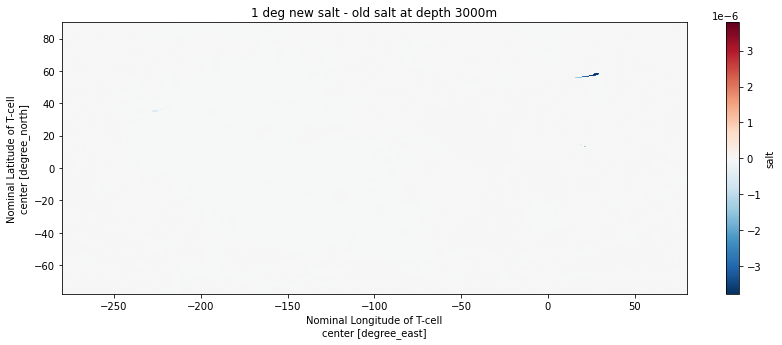

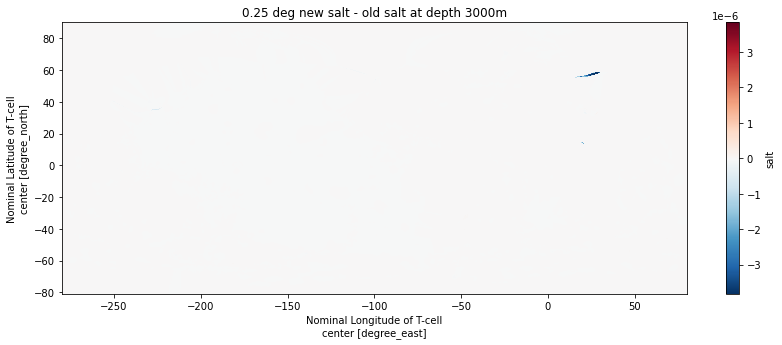

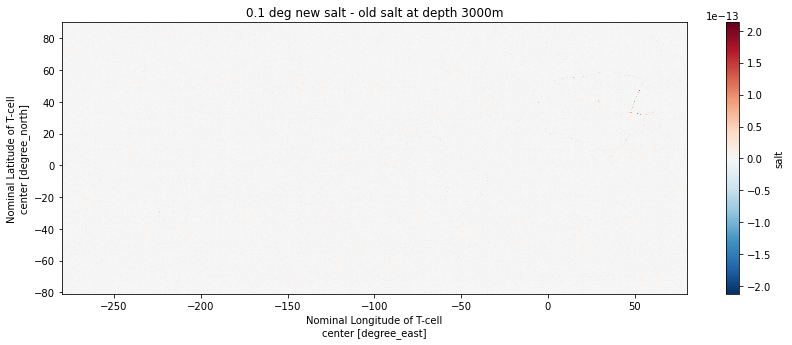

In [41]:
variables = ['temp', 'salt']
depths = [0, 500, 1000, 3000]
for v in variables:
    for d in depths:
        for res, f in files.items():
            fig, ax1  = plt.subplots(1,1,figsize=(14,5))
            plt.subplot(1,1,1)
            old = xr.open_dataset(f['old'])[v].isel(time=0).sel(ZT=d, method='nearest')
            new = xr.open_dataset(f['new'])[v].isel(time=0).sel(ZT=d, method='nearest')
            difference = (new - old)
            difference.plot()
            plt.title(res+' new '+v+' - old '+v+' at depth '+str(d)+'m')